In [6]:
from pydub import AudioSegment

pathSong = "/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav"
audio = AudioSegment.from_mp3(pathSong)
audio.export(pathSong, format="wav")


<_io.BufferedRandom name='/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav'>

In [33]:
# Import the extract_full_song function from our module
from extract_full_midi import extract_full_song

# Set the path to your audio file
pathSong = "/workspace/src/assets/other_segment.wav"

# Set the output path for the MIDI file
output_midi_path = 'midi_files/full_song_output.mid'

# Extract the full song using our improved extraction function
model_output, midi_data, note_events = extract_full_song(pathSong, output_midi_path)

print("Extraction complete! Your MIDI file is ready for chord analysis.")


Extracting notes from full audio: /workspace/src/assets/other_segment.wav
Audio duration: 50.00 seconds, Sample rate: 48000 Hz
Predicting MIDI for /workspace/src/assets/other_segment.wav...


/workspace/src/extract_full_midi.py:29: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)


Extracted 875 notes across 1 instruments to midi_files/full_song_output.mid
Extraction complete! Your MIDI file is ready for chord analysis.


In [ ]:
from music21 import converter, chord

# Load MIDI file
midi = converter.parse('midi_files/output.mid')

# Extract chords
chords = midi.chordify()

# Print extracted chords
for c in chords.recurse().getElementsByClass(chord.Chord):
    print(f"Chord: {c.commonName}, Notes: {[note.nameWithOctave for note in c.notes]}")


Analyzing MIDI file: /workspace/src/midi_files/full_song_output.mid
MIDI parsed successfully with 1 parts
Detected audio tempo: 117.45 BPM
Using audio tempo: 117.45 BPM
Extracted 961 total notes from the MIDI file

=== Chord Analysis by 2-Beat Windows ===
Window 1: Beats 0.0-2.0 (0.00s-1.02s)
  Chord: B-dim7 | Bass: B- | Most common: B-
  Notes: B-, C#, D, E, F, G
  Total notes in window: 11
--------------------------------------------------------------------------------
Window 2: Beats 2.0-4.0 (1.02s-2.04s)
  Chord: A7 | Bass: A | Most common: G
  Notes: A, B-, C, C#, D, E, F, G
  Total notes in window: 15
--------------------------------------------------------------------------------
Window 3: Beats 4.0-6.0 (2.04s-3.07s)
  Chord: Dmin7 | Bass: D | Most common: A
  Notes: A, C, D, E, E-, F
  Total notes in window: 15
--------------------------------------------------------------------------------
Window 4: Beats 6.0-8.0 (3.07s-4.09s)
  Chord: F7 | Bass: F | Most common: F
  Notes: A,

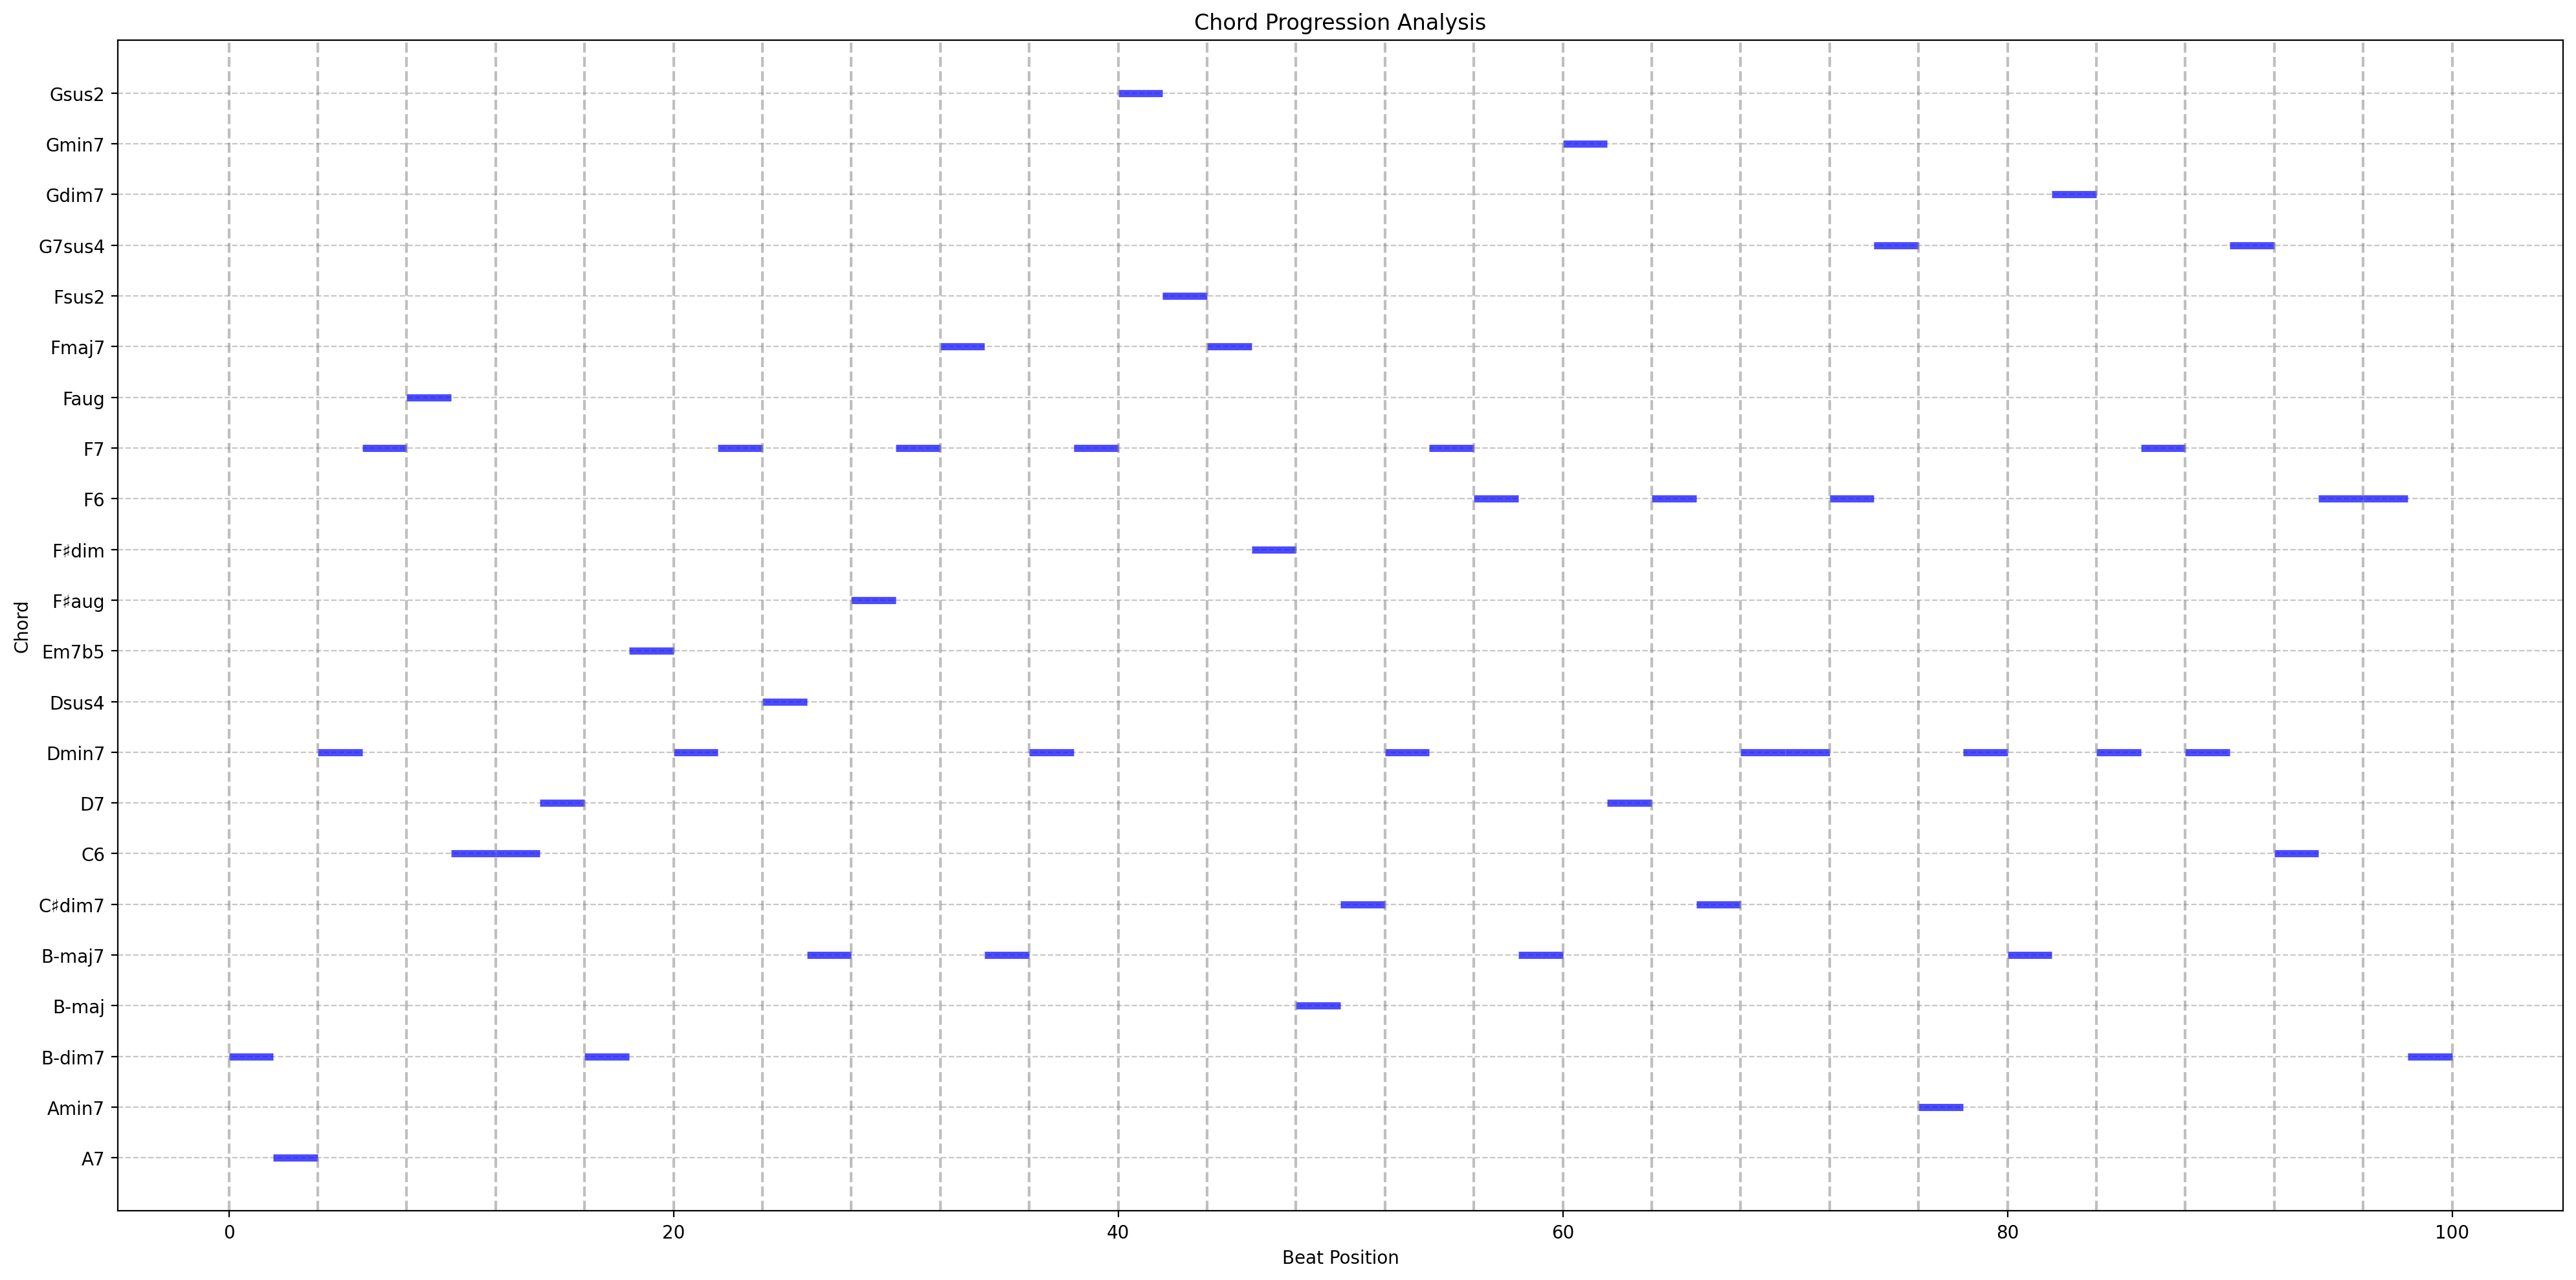

Analysis complete!


In [34]:
import numpy as np
import librosa
import music21
from music21 import converter, chord, note, stream, pitch
from collections import Counter
import matplotlib.pyplot as plt

# Cell 1: Define chord structures based on universal music theory principles
# Each chord type includes a list of REQUIRED intervals that must be present
CHORD_TYPES = {
    # Seventh chords - common in jazz, rock, and other genres
    "7": {
        "intervals": [0, 4, 7, 10],       # Dominant seventh
        "required": [0, 4, 10],           # Root, major 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "maj7": {
        "intervals": [0, 4, 7, 11],       # Major seventh
        "required": [0, 4, 11],           # Root, major 3rd, major 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "min7": {
        "intervals": [0, 3, 7, 10],       # Minor seventh
        "required": [0, 3, 10],           # Root, minor 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "dim7": {
        "intervals": [0, 3, 6, 9],        # Diminished seventh
        "required": [0, 3, 6],            # Root, minor 3rd, diminished 5th MUST be present
        "score_boost": 1.0                # Less common but important
    },
    "m7b5": {
        "intervals": [0, 3, 6, 10],       # Half-diminished seventh
        "required": [0, 3, 6, 10],        # All intervals needed
        "score_boost": 1.0                # Less common but important
    },
    
    # Extensions and alterations - found in jazz and modern music
    "7#11": {
        "intervals": [0, 4, 7, 10, 6],    # Dominant seventh with #11
        "required": [0, 4, 10, 6],        # Root, major 3rd, minor 7th, #11 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    "7b13": {
        "intervals": [0, 4, 7, 10, 8],    # Dominant seventh with b13
        "required": [0, 4, 10, 8],        # Root, major 3rd, minor 7th, b13 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    "7b9": {
        "intervals": [0, 4, 7, 10, 1],    # Dominant seventh with b9
        "required": [0, 4, 10, 1],        # Root, major 3rd, minor 7th, b9 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    "7#9": {
        "intervals": [0, 4, 7, 10, 3],    # Dominant seventh with #9
        "required": [0, 4, 10, 3],        # Root, major 3rd, minor 7th, #9 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    
    # Extended chords
    "9": {
        "intervals": [0, 4, 7, 10, 2],    # Dominant ninth
        "required": [0, 4, 10, 2],        # Root, major 3rd, minor 7th, 9th MUST be present
        "score_boost": 1.0                # Common extension
    },
    "maj9": {
        "intervals": [0, 4, 7, 11, 2],    # Major ninth
        "required": [0, 4, 11, 2],        # Root, major 3rd, major 7th, 9th MUST be present
        "score_boost": 1.0                # Common extension
    },
    "min9": {
        "intervals": [0, 3, 7, 10, 2],    # Minor ninth
        "required": [0, 3, 10, 2],        # Root, minor 3rd, minor 7th, 9th MUST be present
        "score_boost": 1.0                # Common extension
    },
    
    # Sus chords
    "7sus4": {
        "intervals": [0, 5, 7, 10],       # Dominant seventh suspended fourth
        "required": [0, 5, 10],           # Root, perfect 4th, minor 7th MUST be present
        "score_boost": 0.5                # Less common
    },
    "sus4": {
        "intervals": [0, 5, 7],           # Suspended fourth
        "required": [0, 5],               # Root and perfect 4th MUST be present
        "score_boost": 0.0                # Neutral score
    },
    "sus2": {
        "intervals": [0, 2, 7],           # Suspended second
        "required": [0, 2],               # Root and major 2nd MUST be present
        "score_boost": 0.0                # Neutral score
    },
    
    # Sixth chords
    "6": {
        "intervals": [0, 4, 7, 9],        # Major sixth
        "required": [0, 4, 9],            # Root, major 3rd, 6th MUST be present
        "score_boost": 0.5                # Common chord type
    },
    "min6": {
        "intervals": [0, 3, 7, 9],        # Minor sixth
        "required": [0, 3, 9],            # Root, minor 3rd, 6th MUST be present
        "score_boost": 0.5                # Common chord type
    },
    
    # Basic triads - foundational to most Western music
    "maj": {
        "intervals": [0, 4, 7],           # Major triad
        "required": [0, 4],               # Root and major 3rd MUST be present
        "score_boost": 0.0                # Neutral score - basic chord type
    },
    "min": {
        "intervals": [0, 3, 7],           # Minor triad
        "required": [0, 3],               # Root and minor 3rd MUST be present
        "score_boost": 0.0                # Neutral score - basic chord type
    },
    "dim": {
        "intervals": [0, 3, 6],           # Diminished triad
        "required": [0, 3, 6],            # All intervals must be present 
        "score_boost": 0.0                # Neutral score
    },
    "aug": {
        "intervals": [0, 4, 8],           # Augmented triad
        "required": [0, 4, 8],            # All intervals must be present
        "score_boost": 0.0                # Neutral score
    }
}

# Cell 2: Define helper functions for note analysis
def extract_bass_and_harmony(notes_list):
    """
    Extract detailed information from the notes list with advanced weighting
    for bass detection and harmony analysis.
    """
    if not notes_list:
        return {
            'bass': None,
            'most_common': None,
            'pitch_classes': set(),
            'weighted_pitches': {},
            'all_notes': []
        }
    
    # Sort by pitch to find lowest notes
    sorted_by_pitch = sorted(notes_list, key=lambda x: x['pitch'])
    lowest_pitch = sorted_by_pitch[0]['pitch']
    
    # Bass range - based on music theory (bass usually in lower register)
    bass_threshold = lowest_pitch + 5  # Bass notes within 5 semitones of the lowest
    
    # Get bass register notes
    bass_notes = [n for n in sorted_by_pitch if n['pitch'] <= bass_threshold]
    
    # Weight bass notes by duration and position
    bass_counter = Counter()
    for n in bass_notes:
        duration = n['end'] - n['start'] 
        
        # Emphasize notes that start on strong beats (assume 4/4 time)
        beat_position = n['start'] % 4
        beat_emphasis = 1.5 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        # Extra emphasis for the very lowest notes
        lowest_emphasis = 2.0 if n['pitch'] <= lowest_pitch + 2 else 1.0
        
        bass_counter[n['pitch_class']] += duration * beat_emphasis * lowest_emphasis
    
    # Get most likely bass note
    bass_pc = bass_counter.most_common(1)[0][0] if bass_counter else sorted_by_pitch[0]['pitch_class']
    
    # Weight all notes by duration and beat emphasis
    harmony_counter = Counter()
    for n in notes_list:
        pitch_class = n['pitch_class']
        duration = n['end'] - n['start']
        
        # Emphasize notes that start on strong beats
        beat_position = n['start'] % 4
        beat_emphasis = 1.3 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        harmony_counter[pitch_class] += duration * beat_emphasis
    
    # Get most common note overall
    most_common_pc = harmony_counter.most_common(1)[0][0] if harmony_counter else None
    
    # Get all pitch classes
    pitch_classes = set(n['pitch_class'] for n in notes_list)
    
    # Get all note names (for debugging)
    all_notes = sorted(set(n['name'] for n in notes_list))
    
    return {
        'bass': bass_pc,
        'most_common': most_common_pc,
        'pitch_classes': pitch_classes,
        'weighted_pitches': {pc: count for pc, count in harmony_counter.items()},
        'all_notes': all_notes,
        'pitch_class_list': sorted(list(pitch_classes))
    }

# Cell 3: Universal chord identification function
def identify_chord(note_info):
    """
    Identify the most likely chord based on the note information,
    using universal music theory principles that apply to any genre.
    """
    if not note_info['pitch_classes']:
        return "N.C."  # No Chord
    
    # Priority order for potential roots:
    # 1. Bass note
    # 2. Most common note
    # 3. Other notes
    potential_roots = []
    
    if note_info['bass'] is not None:
        potential_roots.append(note_info['bass'])
    
    if note_info['most_common'] is not None and note_info['most_common'] != note_info['bass']:
        potential_roots.append(note_info['most_common'])
    
    for pc in note_info['pitch_classes']:
        if pc not in potential_roots:
            potential_roots.append(pc)
    
    # Track best matching chord
    best_match = {"root": None, "quality": "", "score": 0}
    
    # Try each potential root
    for root in potential_roots:
        # Calculate intervals relative to this root
        intervals = sorted([(pc - root) % 12 for pc in note_info['pitch_classes']])
        
        # Check each chord type
        for quality, chord_data in CHORD_TYPES.items():
            # Get pattern and required intervals
            pattern = chord_data["intervals"]
            required = chord_data["required"]
            score_boost = chord_data.get("score_boost", 0)
            
            # Check if ALL required intervals are present
            if not all(req in intervals for req in required):
                continue  # Skip this chord type if missing any required intervals
                
            # Calculate match statistics
            matched_intervals = set(intervals).intersection(set(pattern))
            missing_intervals = set(pattern) - set(matched_intervals)
            extra_intervals = set(intervals) - set(pattern)
            
            # Calculate match score
            match_percentage = len(matched_intervals) / len(pattern)
            score = match_percentage * 10 - len(extra_intervals) * 0.3 + score_boost
            
            # Bonus if the root matches the bass
            if root == note_info['bass']:
                score += 2.0
                
            # Bonus if the root matches the most common note
            if root == note_info['most_common']:
                score += 1.0
            
            # Update best match if this is better
            if score > best_match["score"]:
                best_match = {
                    "root": root, 
                    "quality": quality, 
                    "score": score
                }
    
    # If we found a decent match
    if best_match["root"] is not None and best_match["score"] > 4:
        # Format root name with proper accidentals
        root_name = format_note_name(best_match["root"])
        return f"{root_name}{best_match['quality']}"
    
    # Special case handling for common chord types
    
    # Handle sus4 chords
    for root in potential_roots:
        intervals = [(pc - root) % 12 for pc in note_info['pitch_classes']]
        if 0 in intervals and 5 in intervals and 7 in intervals and 10 in intervals:
            return f"{format_note_name(root)}7sus4"
        if 0 in intervals and 5 in intervals and 7 in intervals:
            return f"{format_note_name(root)}sus4"
    
    # Special case for Am7sus4 (A, C, F, G) - a common chord in many genres
    if sorted(note_info['pitch_class_list']) == sorted([9, 0, 5, 7]):
        return "Am7sus4"
    
    # Handle power chords (root + fifth only)
    if len(note_info['pitch_classes']) == 2:
        root = note_info['bass']
        if (root + 7) % 12 in note_info['pitch_classes']:
            return f"{format_note_name(root)}5"
    
    # If no good match, return root note or bass note
    return format_note_name(note_info['bass'] if note_info['bass'] is not None else potential_roots[0])

def format_note_name(pitch_class):
    """Format a pitch class as a note name with proper accidentals"""
    root_name = pitch.Pitch(pitch_class).name
    if len(root_name) > 1 and 'b' in root_name:
        return root_name.replace('b', '♭')
    elif len(root_name) > 1 and '#' in root_name:
        return root_name.replace('#', '♯')
    return root_name

# Cell 4: Main analysis function
def analyze_midi_file(midi_path, audio_path=None, window_size=2, overlap=0):
    """
    Analyze a MIDI file to extract chords with advanced detection.
    Works for any style of music.
    
    Args:
        midi_path: Path to the MIDI file
        audio_path: Optional path to corresponding audio file for tempo
        window_size: Size of each window in beats
        overlap: Overlap between windows (0-1 range)
    
    Returns:
        Dictionary with analysis results
    """
    print(f"Analyzing MIDI file: {midi_path}")
    
    # Load MIDI file
    midi = converter.parse(midi_path)
    print(f"MIDI parsed successfully with {len(midi.parts)} parts")
    
    # Determine tempo
    # Determine tempo
    tempo = None
    if audio_path:
        try:
            y, sr = librosa.load(audio_path)
            tempo_audio, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
            tempo = tempo_audio
            print(f"Detected audio tempo: {tempo:.2f} BPM")
        except Exception as e:
            print(f"Error detecting tempo from audio: {e}")

    # Check MIDI tempo only if audio tempo is not available
    midi_tempo_info = midi.metronomeMarkBoundaries()
    if tempo is None and midi_tempo_info:
        midi_tempo = midi_tempo_info[0][2].number
        tempo = midi_tempo
        print(f"Using MIDI tempo: {tempo:.2f} BPM")
    else:
        print(f"Using audio tempo: {tempo:.2f} BPM")

    
    seconds_per_beat = 60 / tempo
    
    # Extract notes with pitch information
    all_notes = []
    for part in midi.parts:
        for note_obj in part.flatten().notesAndRests:
            if isinstance(note_obj, note.Note):
                all_notes.append({
                    'start': note_obj.offset,
                    'end': note_obj.offset + note_obj.duration.quarterLength,
                    'pitch': note_obj.pitch.midi,
                    'name': note_obj.pitch.name,
                    'pitch_class': note_obj.pitch.pitchClass
                })
            elif isinstance(note_obj, chord.Chord):
                for p in note_obj.pitches:
                    all_notes.append({
                        'start': note_obj.offset,
                        'end': note_obj.offset + note_obj.duration.quarterLength,
                        'pitch': p.midi,
                        'name': p.name,
                        'pitch_class': p.pitchClass
                    })
    
    print(f"Extracted {len(all_notes)} total notes from the MIDI file")
    
    # Sort notes by start time
    all_notes.sort(key=lambda x: x['start'])
    
    # Find end time
    if all_notes:
        end_time = max(note['end'] for note in all_notes)
    else:
        end_time = 0
    
    # Create windows
    windows = []
    current_pos = 0
    window_step = window_size * (1 - overlap)
    
    while current_pos < end_time:
        window_end = current_pos + window_size
        windows.append({
            'start': current_pos,
            'end': window_end,
            'notes': []
        })
        current_pos += window_step
    
    # Assign notes to windows
    for note_data in all_notes:
        for window in windows:
            if note_data['end'] > window['start'] and note_data['start'] < window['end']:
                window['notes'].append(note_data)
    
    # Analyze each window
    window_chords = []
    for i, window in enumerate(windows):
        notes_in_window = window['notes']
        
        if notes_in_window:
            # Get detailed note information
            note_info = extract_bass_and_harmony(notes_in_window)
            
            # Identify chord
            chord_name = identify_chord(note_info)
            
            # Create window data
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': chord_name,
                'bass_note': pitch.Pitch(note_info['bass']).nameWithOctave if note_info['bass'] is not None else None,
                'most_common_note': pitch.Pitch(note_info['most_common']).name if note_info['most_common'] is not None else None,
                'bag_of_notes': note_info['all_notes'],
                'note_count': len(notes_in_window),
                'pitch_classes': sorted(list(note_info['pitch_classes']))
            })
        else:
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': "N.C.",
                'bass_note': None,
                'most_common_note': None,
                'bag_of_notes': [],
                'note_count': 0,
                'pitch_classes': []
            })
    
    # Print results
    print(f"\n=== Chord Analysis by {window_size}-Beat Windows ===")
    for wc in window_chords:
        notes_str = ", ".join(wc['bag_of_notes']) if wc['bag_of_notes'] else "None"
        print(f"Window {wc['window']}: Beats {wc['start_beat']:.1f}-{wc['end_beat']:.1f} " +
              f"({wc['start_time']:.2f}s-{wc['end_time']:.2f}s)")
        print(f"  Chord: {wc['chord']} | Bass: {wc['bass_note']} | Most common: {wc['most_common_note']}")
        print(f"  Notes: {notes_str}")
        print(f"  Total notes in window: {wc['note_count']}")
        print("-" * 80)
    
    # Calculate number of bars
    beats_per_bar = 4  # Assuming 4/4 time
    total_bars = int(end_time / beats_per_bar) + 1
    
    # Print chord progression by individual bars
    print("\n=== Chord Progression by Bar ===")
    for bar in range(1, total_bars + 1):
        bar_start = (bar - 1) * beats_per_bar
        bar_end = bar * beats_per_bar
        
        # Find windows that overlap with this bar
        bar_windows = []
        for w in window_chords:
            # Window must significantly overlap with the bar (at least 1/4 beat)
            if w['start_beat'] < bar_end and w['end_beat'] > bar_start:
                overlap_start = max(w['start_beat'], bar_start)
                overlap_end = min(w['end_beat'], bar_end)
                overlap_amount = overlap_end - overlap_start
                
                if overlap_amount >= 0.25:  # At least 1/4 beat overlap
                    bar_windows.append((w, overlap_amount))
        
        if bar_windows:
            # Sort by overlap amount to prioritize windows that cover more of the bar
            bar_windows.sort(key=lambda x: x[1], reverse=True)
            chord_names = [w[0]['chord'] for w in bar_windows]
            print(f"Bar {bar}: {' | '.join(chord_names)}")
    
    # Return analysis results
    return {
        'song_info': {
            'midi_path': midi_path,
            'audio_path': audio_path,
            'tempo': tempo,
            'total_windows': len(window_chords),
            'total_bars': total_bars
        },
        'windows': window_chords
    }

# Cell 5: Visualization function
def visualize_chord_progression(results):
    """
    Create a visual representation of the chord progression
    without any song-specific optimization.
    """
    if not results or 'windows' not in results:
        print("No analysis results to visualize")
        return
    
    windows = results['windows']
    chords = [w['chord'] for w in windows]
    positions = [w['start_beat'] for w in windows]
    
    # Get unique chord names for y-axis, using a universal sorting approach
    # We'll sort alphabetically, which works for any song
    unique_chords = sorted(set(chords), key=lambda x: x.replace('♭', 'b').replace('♯', '#'))
    
    # Create the mapping from chord name to position
    chord_indices = {chord: i for i, chord in enumerate(unique_chords)}
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot each chord
    for i, (chord, pos) in enumerate(zip(chords, positions)):
        # Last element needs special handling
        if i < len(chords) - 1:
            plt.hlines(
                chord_indices[chord],
                pos,
                positions[i+1],
                linewidth=4,
                color='blue',
                alpha=0.7
            )
        else:
            # For last chord, use same duration as previous
            if i > 0:
                duration = positions[i] - positions[i-1]
            else:
                duration = 2  # Default duration if only one chord
            plt.hlines(
                chord_indices[chord],
                pos,
                pos + duration,
                linewidth=4,
                color='blue',
                alpha=0.7
            )
    
    # Add bar lines
    if 'song_info' in results and 'tempo' in results['song_info']:
        bar_positions = range(0, int(max(positions)) + 4, 4)
        for bar_pos in bar_positions:
            plt.axvline(x=bar_pos, color='gray', linestyle='--', alpha=0.5)
    
    # Set labels and grid
    plt.yticks(range(len(unique_chords)), unique_chords)
    plt.ylabel('Chord')
    plt.xlabel('Beat Position')
    plt.title('Chord Progression Analysis')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Cell 6: Run the analysis
# Set file paths
midi_path = '/workspace/src/midi_files/full_song_output.mid'
audio_path = "/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav" 

# Run analysis with 2-beat windows
results = analyze_midi_file(midi_path, audio_path, window_size=2, overlap=0)

# Display visualization
visualize_chord_progression(results)

print("Analysis complete!")

Analyzing MIDI file: /workspace/src/midi_files/full_song_output.mid
MIDI parsed successfully with 1 parts
Detected audio tempo: 117.45 BPM
Using tempo: 117.45 BPM
Extracted 961 total notes from the MIDI file

=== Chord Analysis by 1-Beat Windows ===
Window 1: Beats 0.0-1.0 (0.00s-0.51s)
  Chord: B-maj/F | Bass: F | Most common: B-
  Notes: B-, D, F
  Total notes in window: 6
--------------------------------------------------------------------------------
Window 2: Beats 1.0-2.0 (0.51s-1.02s)
  Chord: B-dim7 | Bass: B- | Most common: E
  Notes: B-, C#, E, G
  Total notes in window: 5
--------------------------------------------------------------------------------
Window 3: Beats 2.0-3.0 (1.02s-1.53s)
  Chord: Gdim7 | Bass: G | Most common: G
  Notes: B-, C#, E, G
  Total notes in window: 7
--------------------------------------------------------------------------------
Window 4: Beats 3.0-4.0 (1.53s-2.04s)
  Chord: Dmin7/A | Bass: A | Most common: C
  Notes: A, C, D, F
  Total notes in 

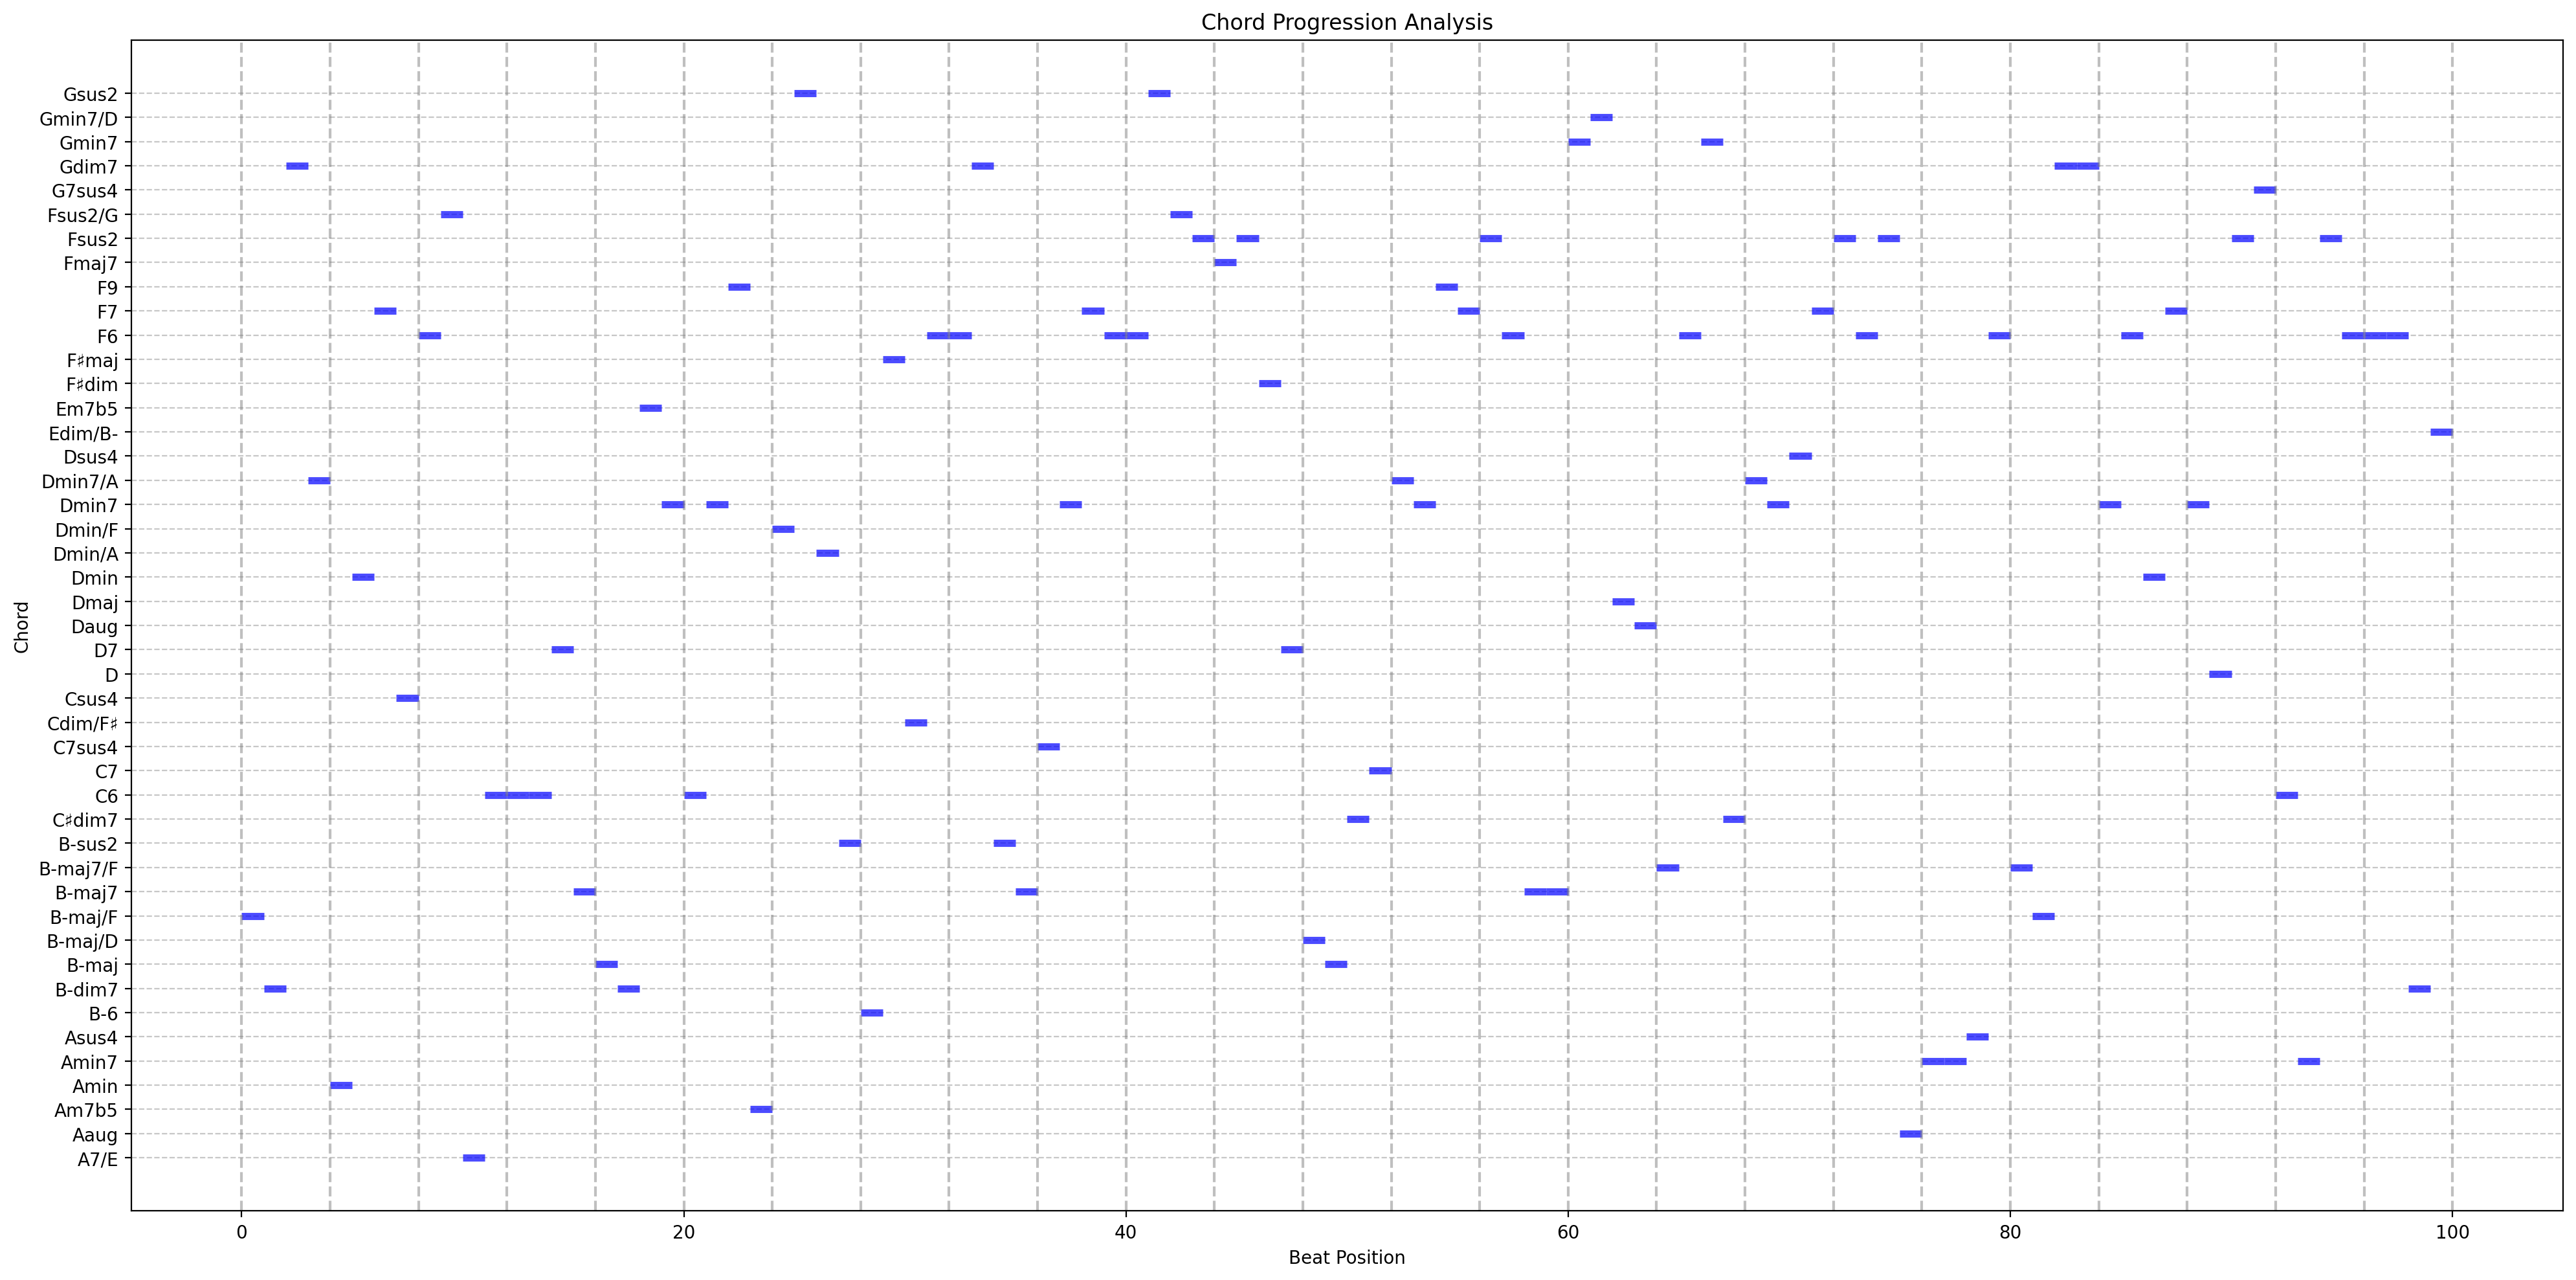

Analysis complete!


In [35]:
import numpy as np
import librosa
import music21
from music21 import converter, chord, note, stream, pitch
from collections import Counter
import matplotlib.pyplot as plt

# Cell 1: Define chord structures based on universal music theory principles
CHORD_TYPES = {
    # Seventh chords - common in jazz, rock, and other genres
    "7": {
        "intervals": [0, 4, 7, 10],       # Dominant seventh
        "required": [0, 4, 10],           # Root, major 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "maj7": {
        "intervals": [0, 4, 7, 11],       # Major seventh
        "required": [0, 4, 11],           # Root, major 3rd, major 7th MUST be present
        "score_boost": 1.5                
    },
    "min7": {
        "intervals": [0, 3, 7, 10],       # Minor seventh
        "required": [0, 3, 10],           # Root, minor 3rd, minor 7th MUST be present
        "score_boost": 1.5                
    },
    "dim7": {
        "intervals": [0, 3, 6, 9],        # Diminished seventh
        "required": [0, 3, 6],            # Root, minor 3rd, diminished 5th MUST be present
        "score_boost": 1.0                
    },
    "m7b5": {
        "intervals": [0, 3, 6, 10],       # Half-diminished seventh
        "required": [0, 3, 6, 10],        # All intervals needed
        "score_boost": 1.0                
    },
    
    # Extensions and alterations
    "7#11": {
        "intervals": [0, 4, 7, 10, 6],    
        "required": [0, 4, 10, 6],        
        "score_boost": 1.0                
    },
    "7b13": {
        "intervals": [0, 4, 7, 10, 8],    
        "required": [0, 4, 10, 8],        
        "score_boost": 1.0                
    },
    "7b9": {
        "intervals": [0, 4, 7, 10, 1],    
        "required": [0, 4, 10, 1],        
        "score_boost": 1.0                
    },
    "7#9": {
        "intervals": [0, 4, 7, 10, 3],    
        "required": [0, 4, 10, 3],        
        "score_boost": 1.0                
    },
    
    # Extended chords
    "9": {
        "intervals": [0, 4, 7, 10, 2],    
        "required": [0, 4, 10, 2],        
        "score_boost": 1.0                
    },
    "maj9": {
        "intervals": [0, 4, 7, 11, 2],    
        "required": [0, 4, 11, 2],        
        "score_boost": 1.0                
    },
    "min9": {
        "intervals": [0, 3, 7, 10, 2],    
        "required": [0, 3, 10, 2],        
        "score_boost": 1.0                
    },
    
    # Sus chords
    "7sus4": {
        "intervals": [0, 5, 7, 10],       
        "required": [0, 5, 10],           
        "score_boost": 0.5                
    },
    "sus4": {
        "intervals": [0, 5, 7],           
        "required": [0, 5],               
        "score_boost": 0.0                
    },
    "sus2": {
        "intervals": [0, 2, 7],           
        "required": [0, 2],               
        "score_boost": 0.0                
    },
    
    # Sixth chords
    "6": {
        "intervals": [0, 4, 7, 9],        
        "required": [0, 4, 9],            
        "score_boost": 0.5                
    },
    "min6": {
        "intervals": [0, 3, 7, 9],        
        "required": [0, 3, 9],            
        "score_boost": 0.5                
    },
    
    # Basic triads
    "maj": {
        "intervals": [0, 4, 7],           
        "required": [0, 4],               
        "score_boost": 0.0                
    },
    "min": {
        "intervals": [0, 3, 7],           
        "required": [0, 3],               
        "score_boost": 0.0                
    },
    "dim": {
        "intervals": [0, 3, 6],           
        "required": [0, 3, 6],            
        "score_boost": 0.0                
    },
    "aug": {
        "intervals": [0, 4, 8],           
        "required": [0, 4, 8],            
        "score_boost": 0.0                
    }
}

# Cell 2: Define helper functions for note analysis
def extract_bass_and_harmony(notes_list):
    """
    Extract detailed information from the notes list with advanced weighting
    for bass detection and harmony analysis.
    """
    if not notes_list:
        return {
            'bass': None,
            'most_common': None,
            'pitch_classes': set(),
            'weighted_pitches': {},
            'all_notes': [],
            'pitch_class_list': []
        }
    
    # Sort by pitch to find lowest notes
    sorted_by_pitch = sorted(notes_list, key=lambda x: x['pitch'])
    lowest_pitch = sorted_by_pitch[0]['pitch']
    bass_threshold = lowest_pitch + 5  # Bass notes within 5 semitones of the lowest
    
    bass_counter = Counter()
    for n in [n for n in sorted_by_pitch if n['pitch'] <= bass_threshold]:
        duration = n['end'] - n['start']
        beat_position = n['start'] % 4
        beat_emphasis = 1.5 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        lowest_emphasis = 2.0 if n['pitch'] <= lowest_pitch + 2 else 1.0
        bass_counter[n['pitch_class']] += duration * beat_emphasis * lowest_emphasis
    
    bass_pc = bass_counter.most_common(1)[0][0] if bass_counter else sorted_by_pitch[0]['pitch_class']
    
    harmony_counter = Counter()
    for n in notes_list:
        duration = n['end'] - n['start']
        beat_position = n['start'] % 4
        beat_emphasis = 1.3 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        harmony_counter[n['pitch_class']] += duration * beat_emphasis
    
    most_common_pc = harmony_counter.most_common(1)[0][0] if harmony_counter else None
    pitch_classes = set(n['pitch_class'] for n in notes_list)
    all_notes = sorted(set(n['name'] for n in notes_list))
    
    return {
        'bass': bass_pc,
        'most_common': most_common_pc,
        'pitch_classes': pitch_classes,
        'weighted_pitches': dict(harmony_counter),
        'all_notes': all_notes,
        'pitch_class_list': sorted(list(pitch_classes))
    }

def format_note_name(pitch_class):
    """Format a pitch class as a note name with proper accidentals."""
    root_name = pitch.Pitch(pitch_class).name
    if 'b' in root_name:
        return root_name.replace('b', '♭')
    elif '#' in root_name:
        return root_name.replace('#', '♯')
    return root_name

# Cell 3: Universal chord identification function with inversion notation
def identify_chord(note_info):
    """
    Identify the most likely chord based on the note information using universal music theory.
    Returns a slash chord if the bass note is not the chord's identified root.
    """
    if not note_info['pitch_classes']:
        return "N.C."  # No Chord
    
    potential_roots = []
    if note_info['bass'] is not None:
        potential_roots.append(note_info['bass'])
    if note_info['most_common'] is not None and note_info['most_common'] != note_info['bass']:
        potential_roots.append(note_info['most_common'])
    for pc in note_info['pitch_classes']:
        if pc not in potential_roots:
            potential_roots.append(pc)
    
    best_match = {"root": None, "quality": "", "score": 0}
    for root in potential_roots:
        intervals = sorted([(pc - root) % 12 for pc in note_info['pitch_classes']])
        for quality, chord_data in CHORD_TYPES.items():
            pattern = chord_data["intervals"]
            required = chord_data["required"]
            score_boost = chord_data.get("score_boost", 0)
            if not all(req in intervals for req in required):
                continue
            matched_intervals = set(intervals).intersection(set(pattern))
            extra_intervals = set(intervals) - set(pattern)
            match_percentage = len(matched_intervals) / len(pattern)
            score = match_percentage * 10 - len(extra_intervals) * 0.3 + score_boost
            if root == note_info['bass']:
                score += 2.0
            if root == note_info['most_common']:
                score += 1.0
            if score > best_match["score"]:
                best_match = {"root": root, "quality": quality, "score": score}
    
    # If a good match is found, add inversion (slash chord) if bass differs from identified root.
    if best_match["root"] is not None and best_match["score"] > 4:
        chord_root = format_note_name(best_match["root"])
        chord_name = f"{chord_root}{best_match['quality']}"
        if note_info['bass'] is not None and note_info['bass'] != best_match["root"]:
            chord_name += f"/{format_note_name(note_info['bass'])}"
        return chord_name
    
    # Special cases: sus4 chords, common patterns, power chords
    for root in potential_roots:
        intervals = [(pc - root) % 12 for pc in note_info['pitch_classes']]
        if 0 in intervals and 5 in intervals and 7 in intervals and 10 in intervals:
            return f"{format_note_name(root)}7sus4"
        if 0 in intervals and 5 in intervals and 7 in intervals:
            return f"{format_note_name(root)}sus4"
    if sorted(note_info['pitch_class_list']) == sorted([9, 0, 5, 7]):
        return "Am7sus4"
    if len(note_info['pitch_classes']) == 2:
        root = note_info['bass']
        if (root + 7) % 12 in note_info['pitch_classes']:
            return f"{format_note_name(root)}5"
    
    return format_note_name(note_info['bass'] if note_info['bass'] is not None else potential_roots[0])

# Cell 4: Main analysis function with improved tempo detection
def analyze_midi_file(midi_path, audio_path=None, window_size=2, overlap=0):
    """
    Analyze a MIDI file to extract chords with advanced detection.
    Args:
        midi_path: Path to the MIDI file.
        audio_path: Optional path to an audio file for tempo detection.
        window_size: Size of each window in beats.
        overlap: Overlap between windows (0-1 range).
    Returns:
        Dictionary with analysis results.
    """
    print(f"Analyzing MIDI file: {midi_path}")
    midi = converter.parse(midi_path)
    print(f"MIDI parsed successfully with {len(midi.parts)} parts")
    
    tempo = None
    if audio_path:
        try:
            y, sr = librosa.load(audio_path)
            tempo_audio, _ = librosa.beat.beat_track(y=y, sr=sr)
            tempo = tempo_audio
            print(f"Detected audio tempo: {tempo:.2f} BPM")
        except Exception as e:
            print(f"Error detecting tempo from audio: {e}")
    
    # Use MIDI tempo only if audio tempo was not detected.
    midi_tempo_info = midi.metronomeMarkBoundaries()
    if tempo is None and midi_tempo_info:
        tempo = midi_tempo_info[0][2].number
        print(f"Using MIDI tempo: {tempo:.2f} BPM")
    
    if tempo is None:
        tempo = 120
        print("No tempo detected, using default: 120 BPM")
    else:
        print(f"Using tempo: {tempo:.2f} BPM")
    
    seconds_per_beat = 60 / tempo
    
    # Extract notes with pitch information
    all_notes = []
    for part in midi.parts:
        for note_obj in part.flatten().notesAndRests:
            if isinstance(note_obj, note.Note):
                all_notes.append({
                    'start': note_obj.offset,
                    'end': note_obj.offset + note_obj.duration.quarterLength,
                    'pitch': note_obj.pitch.midi,
                    'name': note_obj.pitch.name,
                    'pitch_class': note_obj.pitch.pitchClass
                })
            elif isinstance(note_obj, chord.Chord):
                for p in note_obj.pitches:
                    all_notes.append({
                        'start': note_obj.offset,
                        'end': note_obj.offset + note_obj.duration.quarterLength,
                        'pitch': p.midi,
                        'name': p.name,
                        'pitch_class': p.pitchClass
                    })
    print(f"Extracted {len(all_notes)} total notes from the MIDI file")
    all_notes.sort(key=lambda x: x['start'])
    end_time = max(n['end'] for n in all_notes) if all_notes else 0
    
    # Create windows
    windows = []
    current_pos = 0
    window_step = window_size * (1 - overlap)
    while current_pos < end_time:
        windows.append({
            'start': current_pos,
            'end': current_pos + window_size,
            'notes': []
        })
        current_pos += window_step
    
    # Assign notes to windows
    for note_data in all_notes:
        for window in windows:
            # Since windows are in order, if note starts after the window ends, break early.
            if note_data['start'] > window['end']:
                continue
            if note_data['end'] > window['start'] and note_data['start'] < window['end']:
                window['notes'].append(note_data)
    
    # Analyze each window
    window_chords = []
    for i, window in enumerate(windows):
        if window['notes']:
            note_info = extract_bass_and_harmony(window['notes'])
            chord_name = identify_chord(note_info)
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': chord_name,
                'bass_note': pitch.Pitch(note_info['bass']).nameWithOctave if note_info['bass'] is not None else None,
                'most_common_note': pitch.Pitch(note_info['most_common']).name if note_info['most_common'] is not None else None,
                'bag_of_notes': note_info['all_notes'],
                'note_count': len(window['notes']),
                'pitch_classes': sorted(list(note_info['pitch_classes']))
            })
        else:
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': "N.C.",
                'bass_note': None,
                'most_common_note': None,
                'bag_of_notes': [],
                'note_count': 0,
                'pitch_classes': []
            })
    
    print(f"\n=== Chord Analysis by {window_size}-Beat Windows ===")
    for wc in window_chords:
        notes_str = ", ".join(wc['bag_of_notes']) if wc['bag_of_notes'] else "None"
        print(f"Window {wc['window']}: Beats {wc['start_beat']:.1f}-{wc['end_beat']:.1f} " +
              f"({wc['start_time']:.2f}s-{wc['end_time']:.2f}s)")
        print(f"  Chord: {wc['chord']} | Bass: {wc['bass_note']} | Most common: {wc['most_common_note']}")
        print(f"  Notes: {notes_str}")
        print(f"  Total notes in window: {wc['note_count']}")
        print("-" * 80)
    
    # Calculate bars and print chord progression by bar
    beats_per_bar = 4  # assuming 4/4 time
    total_bars = int(end_time / beats_per_bar) + 1
    print("\n=== Chord Progression by Bar ===")
    for bar in range(1, total_bars + 1):
        bar_start = (bar - 1) * beats_per_bar
        bar_end = bar * beats_per_bar
        bar_windows = []
        for w in window_chords:
            if w['start_beat'] < bar_end and w['end_beat'] > bar_start:
                overlap_start = max(w['start_beat'], bar_start)
                overlap_end = min(w['end_beat'], bar_end)
                if (overlap_end - overlap_start) >= 0.25:
                    bar_windows.append((w, overlap_end - overlap_start))
        if bar_windows:
            bar_windows.sort(key=lambda x: x[1], reverse=True)
            chord_names = [w[0]['chord'] for w in bar_windows]
            print(f"Bar {bar}: {' | '.join(chord_names)}")
    
    return {
        'song_info': {
            'midi_path': midi_path,
            'audio_path': audio_path,
            'tempo': tempo,
            'total_windows': len(window_chords),
            'total_bars': total_bars
        },
        'windows': window_chords
    }

# Cell 5: Visualization function remains largely the same
def visualize_chord_progression(results):
    if not results or 'windows' not in results:
        print("No analysis results to visualize")
        return
    
    windows = results['windows']
    chords = [w['chord'] for w in windows]
    positions = [w['start_beat'] for w in windows]
    
    unique_chords = sorted(set(chords), key=lambda x: x.replace('♭', 'b').replace('♯', '#'))
    chord_indices = {chord: i for i, chord in enumerate(unique_chords)}
    
    plt.figure(figsize=(20, 10))
    for i, (chord, pos) in enumerate(zip(chords, positions)):
        if i < len(chords) - 1:
            plt.hlines(chord_indices[chord], pos, positions[i+1], linewidth=4, color='blue', alpha=0.7)
        else:
            duration = positions[i] - positions[i-1] if i > 0 else 2
            plt.hlines(chord_indices[chord], pos, pos + duration, linewidth=4, color='blue', alpha=0.7)
    
    bar_positions = range(0, int(max(positions)) + 4, 4)
    for bar_pos in bar_positions:
        plt.axvline(x=bar_pos, color='gray', linestyle='--', alpha=0.5)
    
    plt.yticks(range(len(unique_chords)), unique_chords)
    plt.ylabel('Chord')
    plt.xlabel('Beat Position')
    plt.title('Chord Progression Analysis')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Cell 6: Run the analysis
midi_path = '/workspace/src/midi_files/full_song_output.mid'
audio_path = "/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav" 

results = analyze_midi_file(midi_path, audio_path, window_size=1, overlap=0)
visualize_chord_progression(results)
print("Analysis complete!")
